In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder

# 데이터 로드
train_data_path ="~/aiffel/dktc/data/train.csv"
train_df = pd.read_csv(train_data_path)
submission_df = pd.read_csv("../submit/submission.csv")

# 시각화 스타일 설정
sns.set(style="whitegrid", palette="muted")

# 한글 폰트 설정
plt.rc('font', family='NanumGothic') 

train_df.head(10)

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
5,5,직장 내 괴롭힘 대화,나 이틀뒤에 가나다 음식점 예약좀 해줘. 저녁7시로.\n가나다 음식점이요.?\n응....
6,6,기타 괴롭힘 대화,35번 손님 아이스커피 두잔나왔습니다\n아이스커피? \n네 맛있게드세요\n저기요 아...
7,7,기타 괴롭힘 대화,경비아저씨 내차에 경고장 붙였어요?\n내가 여기 몇년째 사는데 아직도 내차인줄 모르...
8,8,기타 괴롭힘 대화,이거 할인 된다면서요\n 확인해보겠습니다\n 아까 저 시람은 할인 해주던데\n 네 ...
9,9,갈취 대화,자네 세금계산서 보내준 거 메일이랑 수치가 다르던데?\n그게.\n얼마나 해먹었어? ...


In [2]:
train_df.tail(10)

,idx,class,conversation
3940,3940,기타 괴롭힘 대화,애들아 공연 연습하자.\n이번주에 최종 평가 있어. 빨리 하자.\n야 김정미 너는 ...
3941,3941,갈취 대화,동생아 내가 정말 급해서 그러는데 백만원만 빌려줄수있니?\n또?? 무슨일인데 그래?...
3942,3942,갈취 대화,영지야 나 토익 학원 다니느라 돈을 다써서 그런데 5만원만 빌려주라\n응? 안돼. ...
3943,3943,갈취 대화,인테리어 하는데 예상보다 돈이 1200만원 더 들어서 그 돈 주셔야 해요.\n120...
3944,3944,기타 괴롭힘 대화,나를 왜 자꾸 때려\n때리고 싶으니깐.\n내가 뭐 잘못했어?\n아니 잘못없지\n근데...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...
3949,3949,직장 내 괴롭힘 대화,희정씨\n네?\n주말에 시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일...


In [3]:
import pandas as pd

# CLASS_NAMES에 '일반 대화'를 포함시킴
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

# 수동 매핑 설정
class_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

# 'class' 열을 수동 매핑 적용하기 전에 문자열로 변환
train_df['class'] = train_df['class'].astype(str).map(class_mapping)

# NaN 값이 있을 경우 이를 4로 (일반 대화) 처리
train_df['class'] = train_df['class'].fillna(4).astype(int)

# 결과 확인
train_df.head()

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


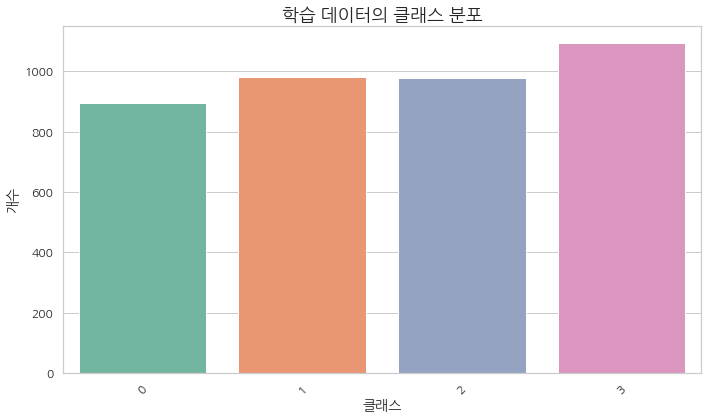

In [4]:
# 1. 학습 데이터의 클래스 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='class', palette='Set2')
plt.title('학습 데이터의 클래스 분포', fontsize=18)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('개수', fontsize=14)
plt.xlabel('클래스', fontsize=14)
plt.tight_layout()

# 그래프 표현
plt.show()

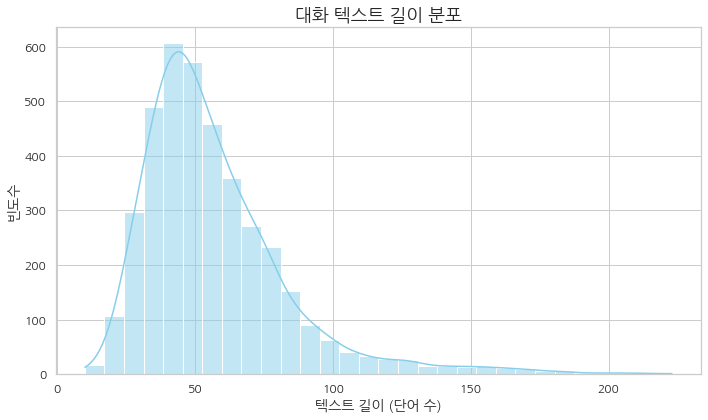

In [5]:
# 텍스트 길이를 계산하는 열 추가
train_df['text_length'] = train_df['conversation'].apply(lambda x: len(str(x).split()))

# 2. 대화의 텍스트 길이 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=30, kde=True, color='skyblue')
plt.title('대화 텍스트 길이 분포', fontsize=18)
plt.xlabel('텍스트 길이 (단어 수)', fontsize=14)
plt.ylabel('빈도수', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# 그래프 표현
plt.show()

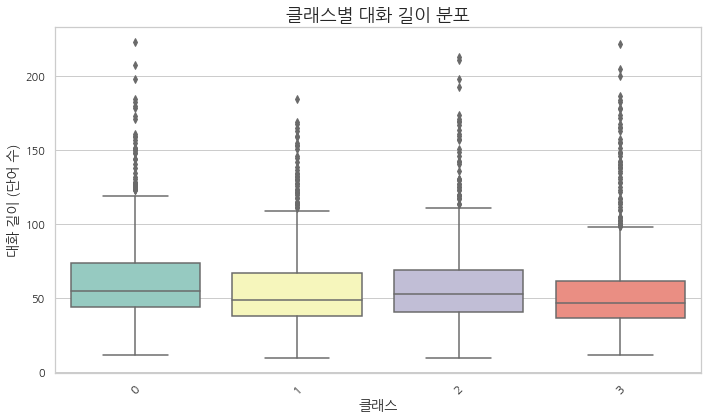

In [6]:
# 3. 클래스별 대화 길이 분포 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='class', y='text_length', palette='Set3')
plt.title('클래스별 대화 길이 분포', fontsize=18)
plt.xlabel('클래스', fontsize=14)
plt.ylabel('대화 길이 (단어 수)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# 그래프 표현
plt.show()

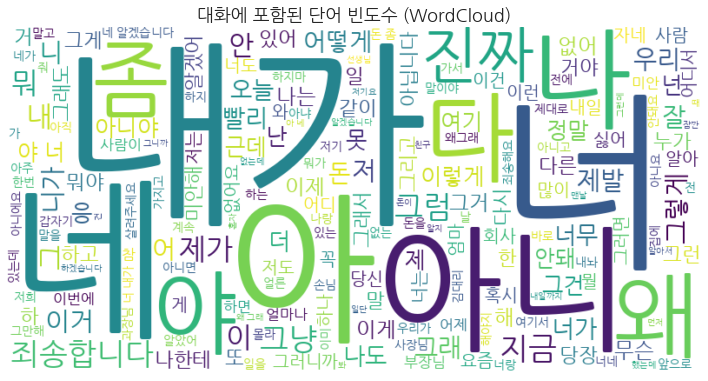

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로 지정 
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 모든 대화 텍스트 합치기
all_text = ' '.join(train_df['conversation'].tolist())

# 워드클라우드 생성 (한글 폰트 적용)
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate(all_text)

# 4. 워드클라우드 시각화
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('대화에 포함된 단어 빈도수 (WordCloud)', fontsize=18)
plt.axis('off')
plt.tight_layout()

# 그래프 표현
plt.show()

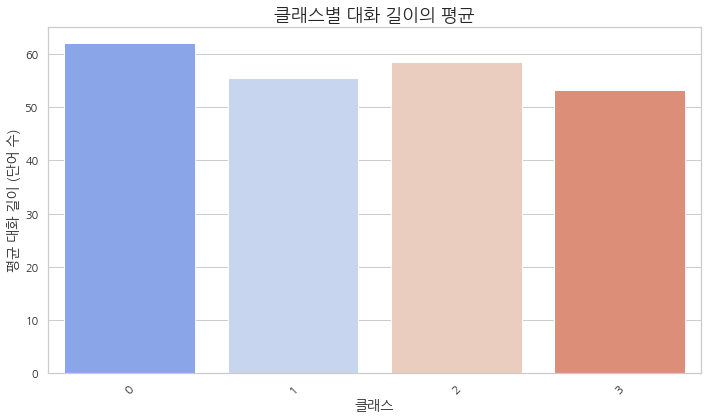

In [8]:
# 클래스별 텍스트 길이 평균 계산
class_length_mean = train_df.groupby('class')['text_length'].mean().sort_values()

# 5. 클래스별 텍스트 길이 평균 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=class_length_mean.index, y=class_length_mean.values, palette='coolwarm')
plt.title('클래스별 대화 길이의 평균', fontsize=18)
plt.xlabel('클래스', fontsize=14)
plt.ylabel('평균 대화 길이 (단어 수)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# 그래프 표현
plt.show()

In [9]:
# 결측치가 있는 데이터만 필터링
missing_data = train_df[train_df.isnull().any(axis=1)]

# 결측치가 있는지 확인
if missing_data.empty:
    print("결측치가 있는 데이터가 없습니다.")
else:
    # 6. 결측치가 있을 때만 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(missing_data.isnull(), cbar=False, cmap='viridis', yticklabels=True)
    plt.title('결측치가 있는 데이터만 시각화', fontsize=18)
    plt.tight_layout()

    # 그래프 표현
    plt.show()

결측치가 있는 데이터가 없습니다.


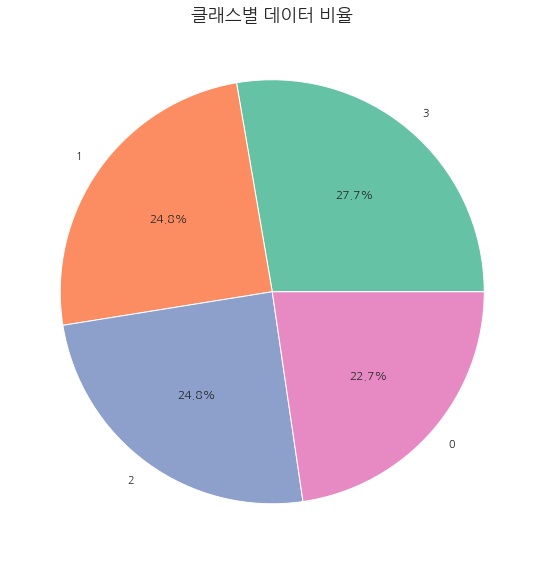

In [10]:
# 7. 클래스별 데이터 비율
class_distribution = train_df['class'].value_counts()

# 파이 차트 시각화
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('클래스별 데이터 비율', fontsize=18)
plt.tight_layout()

# 그래프 표현
plt.show()

# 1. 데이터 특이점
- 클래스 불균형: 시각화를 통해 각 클래스(협박, 갈취, 괴롭힘 등)의 데이터 비율을 살펴보면 클래스의 데이터가 상대적으로 비슷합니다.
- 텍스트 길이의 차이: 각 클래스별로 텍스트 길이의 평균과 분포를 확인할 때, 클래스의 데이터가 상대적으로 비슷합니다. 50~60자 사이가 대부분입니다.
- 결측치: 결측치가 많지 않거나 전혀 없다는 점도 확인되었습니다. 결측치가 없다면 데이터 전처리 단계에서 복잡한 처리가 필요하지 않음을 의미합니다.

# 2. 데이터 증강 전략 - [이미 있는 라벨]
- 백트랜슬레이션: 데이터를 증강하는 좋은 방법으로, 한국어 데이터를 영어로 번역한 후 다시 한국어로 번역하여 새로운 문장을 만들어낼 수 있습니다. 이를 통해 문장의 의미는 유지하면서 새로운 데이터를 얻을 수 있습니다. -> 시간 문제로 보류

In [11]:
'''from googletrans import Translator

# Translator 객체 생성
translator = Translator()

# 백트랜슬레이션 함수
def back_translate(text, src='ko', tmp='en'):
    # 1단계: 한국어 -> 영어 번역
    translated = translator.translate(text, src=src, dest=tmp).text
    # 2단계: 영어 -> 한국어 번역
    back_translated = translator.translate(translated, src=tmp, dest=src).text
    return back_translated

# 예시 대화를 백트랜슬레이션 적용
train_df['backtranslated_conversation'] = train_df['cleaned_conversation'].apply(lambda x: back_translate(x, src='ko', tmp='en'))

# 결과 확인
train_df[['cleaned_conversation', 'backtranslated_conversation']].head()'''

"from googletrans import Translator\n\n# Translator 객체 생성\ntranslator = Translator()\n\n# 백트랜슬레이션 함수\ndef back_translate(text, src='ko', tmp='en'):\n    # 1단계: 한국어 -> 영어 번역\n    translated = translator.translate(text, src=src, dest=tmp).text\n    # 2단계: 영어 -> 한국어 번역\n    back_translated = translator.translate(translated, src=tmp, dest=src).text\n    return back_translated\n\n# 예시 대화를 백트랜슬레이션 적용\ntrain_df['backtranslated_conversation'] = train_df['cleaned_conversation'].apply(lambda x: back_translate(x, src='ko', tmp='en'))\n\n# 결과 확인\ntrain_df[['cleaned_conversation', 'backtranslated_conversation']].head()"

# 3. 데이터 확보 전략 - [일반대화]
- gpt로 생성

In [17]:
import pandas as pd

# 기존 train 데이터와 새로운 general 데이터 로드
new_general_df = pd.read_csv('../../../new_unique_general_conversations.csv')

# 새로운 general 데이터의 'class' 열을 모두 4로 설정
new_general_df['class'] = 4

# 'conversation' 열에서 중복된 대화 제거 (new_general_df 내부에서)
new_general_df = new_general_df.drop_duplicates(subset='conversation')

# 'conversation' 열에서 train_df와 중복된 데이터 제거
new_general_df = new_general_df[~new_general_df['conversation'].isin(train_df['conversation'])]

# idx 열을 3950부터 1씩 증가하도록 설정
new_general_df = new_general_df.reset_index(drop=True)
new_general_df['idx'] = range(3950, 3950 + len(new_general_df))

# 'text_length' 열을 추가하여 각 conversation의 길이를 계산
new_general_df['text_length'] = new_general_df['conversation'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# 데이터 병합
train_df = pd.concat([train_df, new_general_df], ignore_index=True)

# 'conversation' 열에서 단어 수를 계산하여 word_count 열 추가
train_df['word_count'] = train_df['conversation'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

# 병합 후 결과 출력
print("중복 제거 및 데이터 병합 완료!")
train_df.tail()

중복 제거 및 데이터 병합 완료!


,idx,class,conversation,text_length,word_count,cleaned_conversation
4971,4971,4,<s>[INST] 혹시 음식 주문도 가능한가요? [/INST] '제가 업무에 집중하...,175,40,혹시 음식 주문도 가능한가요 제가 업무에 집중하도록 지시 받았기 때문에 음식 주문에...
4972,4972,4,<s>[INST] 대연평도를 향한 북한의 도발 당시 국군이 서해 5도에 이어 전군에...,218,51,대연평도를 향한 북한의 도발 당시 국군이 서해 5도에 이어 전군에 발령한 것은 만약...
4973,4973,4,<s>[INST] 마스터카드 사용으로 나온 매출액이 1년에 얼마나 돼 [/INST]...,244,55,마스터카드 사용으로 나온 매출액이 1년에 얼마나 돼 마스터카드 사용으로 발생한 매출...
4974,4974,4,<s>[INST] 정도전이 성균관에서 경사를 강론하며 특히 능하였던 것은 문장과 무...,269,62,정도전이 성균관에서 경사를 강론하며 특히 능하였던 것은 문장과 무엇인가 정도전이 성...
4975,4975,4,<s>[INST] 포켓몬 체육관에서 보스격인 트레이너는 누구지 [/INST] '?\...,278,61,포켓몬 체육관에서 보스격인 트레이너는 누구지 저는 답변을 드리기 위해서는 어떤 게임...


In [18]:
from datasets import load_dataset

# 데이터셋 로드
ds = load_dataset("Ammad1Ali/Korean-conversational-dataset")

# 'train' 데이터셋을 pandas DataFrame으로 변환
ds = ds['train'].to_pandas()

# 'text' 열을 'conversation'으로 이름 변경
ds = ds.rename(columns={'text': 'conversation'})

# 단어 수가 40~70 사이인 대화만 선택
ds['word_count'] = ds['conversation'].apply(lambda x: len(str(x).split()))
ds_filtered = ds[(ds['word_count'] >= 40) & (ds['word_count'] <= 70)]

# 상위 1000개만 선택
ds_filtered = ds_filtered.head(1000)

# 새로운 general 데이터의 'class' 열을 모두 4로 설정
ds_filtered['class'] = 4

# 'conversation' 열에서 중복된 대화 제거
ds_filtered = ds_filtered.drop_duplicates(subset='conversation')

# 'conversation' 열에서 train_df와 중복된 데이터 제거
ds_filtered = ds_filtered[~ds_filtered['conversation'].isin(train_df['conversation'])]

# idx 열을 3950부터 1씩 증가하도록 설정
ds_filtered = ds_filtered.reset_index(drop=True)
ds_filtered['idx'] = range(3976, 3976 + len(ds_filtered))

# 'text_length' 열을 추가하여 각 conversation의 길이를 계산
ds_filtered['text_length'] = ds_filtered['conversation'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# 데이터 병합
train_df = pd.concat([train_df, ds_filtered], ignore_index=True)

# 병합 후 결과 출력
print("중복 제거 및 데이터 병합 완료!")

train_df.tail()

Using custom data configuration Ammad1Ali___Korean-conversational-dataset-cccafcbc204ca821
Reusing dataset csv (/aiffel/.cache/huggingface/datasets/csv/Ammad1Ali___Korean-conversational-dataset-cccafcbc204ca821/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

중복 제거 및 데이터 병합 완료!


,idx,class,conversation,text_length,word_count,cleaned_conversation
4971,4971,4,<s>[INST] 혹시 음식 주문도 가능한가요? [/INST] '제가 업무에 집중하...,175,40,혹시 음식 주문도 가능한가요 제가 업무에 집중하도록 지시 받았기 때문에 음식 주문에...
4972,4972,4,<s>[INST] 대연평도를 향한 북한의 도발 당시 국군이 서해 5도에 이어 전군에...,218,51,대연평도를 향한 북한의 도발 당시 국군이 서해 5도에 이어 전군에 발령한 것은 만약...
4973,4973,4,<s>[INST] 마스터카드 사용으로 나온 매출액이 1년에 얼마나 돼 [/INST]...,244,55,마스터카드 사용으로 나온 매출액이 1년에 얼마나 돼 마스터카드 사용으로 발생한 매출...
4974,4974,4,<s>[INST] 정도전이 성균관에서 경사를 강론하며 특히 능하였던 것은 문장과 무...,269,62,정도전이 성균관에서 경사를 강론하며 특히 능하였던 것은 문장과 무엇인가 정도전이 성...
4975,4975,4,<s>[INST] 포켓몬 체육관에서 보스격인 트레이너는 누구지 [/INST] '?\...,278,61,포켓몬 체육관에서 보스격인 트레이너는 누구지 저는 답변을 드리기 위해서는 어떤 게임...


# 4. 전처리 전략 - [HOW?]
- 정규화

In [19]:
# 텍스트 정규화: 대화 데이터에서 등장하는 특수 문자, 숫자, 불필요한 공백 등을 제거합니다.

import re

import re

# 텍스트 정규화 함수
def clean_text(text):
    # 한글, 숫자, 공백을 제외한 모든 문자 제거
    text = re.sub(r'[^가-힣0-9\s]', '', text)
    # 여러 개의 공백을 하나의 공백으로
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# 데이터에 적용
train_df['cleaned_conversation'] = train_df['conversation'].apply(clean_text)

train_df.head()

,idx,class,conversation,text_length,word_count,cleaned_conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,52,52,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,39,39,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,52,52,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,34,34,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,118,118,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...


In [20]:
train_df.tail(10)

,idx,class,conversation,text_length,word_count,cleaned_conversation
4966,4966,4,<s>[INST] 다리가 후덜덜 [/INST] '하다는 것은 보통 다리가 힘 없이 ...,285,64,다리가 후덜덜 하다는 것은 보통 다리가 힘 없이 쑤시거나 떨리는 상태를 말합니다 이...
4967,4967,4,<s>[INST] 어떤 빵이 잘 나가는고? 처음 사로 와 갔고 [/INST] '그것...,211,54,어떤 빵이 잘 나가는고 처음 사로 와 갔고 그것은 상황에 따라 다를 수 있습니다 대...
4968,4968,4,<s>[INST] 일반인 옷보다 비싸죠? [/INST] '종종 그럴 수 있지만 일반...,226,54,일반인 옷보다 비싸죠 종종 그럴 수 있지만 일반적으로 그렇지 않습니다 일부 고급 패...
4969,4969,4,"<s>[INST] 마지막입니다. [/INST] '안녕하세요, 저는 OpenAI의 인...",214,42,마지막입니다 안녕하세요 저는 의 인공지능 언어 모델인 3를 사용하는 인공지능 챗봇입...
4970,4970,4,<s>[INST] 가나안 북부에서 일어난 고대 문명은? [/INST] '가나안 북부...,284,58,가나안 북부에서 일어난 고대 문명은 가나안 북부에서 일어난 고대 문명은 고대 카나안...
4971,4971,4,<s>[INST] 혹시 음식 주문도 가능한가요? [/INST] '제가 업무에 집중하...,175,40,혹시 음식 주문도 가능한가요 제가 업무에 집중하도록 지시 받았기 때문에 음식 주문에...
4972,4972,4,<s>[INST] 대연평도를 향한 북한의 도발 당시 국군이 서해 5도에 이어 전군에...,218,51,대연평도를 향한 북한의 도발 당시 국군이 서해 5도에 이어 전군에 발령한 것은 만약...
4973,4973,4,<s>[INST] 마스터카드 사용으로 나온 매출액이 1년에 얼마나 돼 [/INST]...,244,55,마스터카드 사용으로 나온 매출액이 1년에 얼마나 돼 마스터카드 사용으로 발생한 매출...
4974,4974,4,<s>[INST] 정도전이 성균관에서 경사를 강론하며 특히 능하였던 것은 문장과 무...,269,62,정도전이 성균관에서 경사를 강론하며 특히 능하였던 것은 문장과 무엇인가 정도전이 성...
4975,4975,4,<s>[INST] 포켓몬 체육관에서 보스격인 트레이너는 누구지 [/INST] '?\...,278,61,포켓몬 체육관에서 보스격인 트레이너는 누구지 저는 답변을 드리기 위해서는 어떤 게임...


In [21]:
train_df.to_csv('train_df.csv', index=False)